# PS3 solutions

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn.datasets
import sklearn.preprocessing
import sklearn.pipeline
import sklearn.model_selection
import sklearn.linear_model
import sklearn.metrics
import sklearn.feature_selection

In [4]:
bunch_cholesterol = sklearn.datasets.fetch_openml(data_id=204, as_frame=True)

C:\Users\Agonz\mambaforge\envs\ee5830\lib\site-packages\sklearn\datasets\_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [5]:
df_cholesterol = bunch_cholesterol.frame
df_cholesterol.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   age       303 non-null    float64 
 1   sex       303 non-null    category
 2   cp        303 non-null    category
 3   trestbps  303 non-null    float64 
 4   fbs       303 non-null    category
 5   restecg   303 non-null    category
 6   thalach   303 non-null    float64 
 7   exang     303 non-null    category
 8   oldpeak   303 non-null    float64 
 9   slope     303 non-null    category
 10  ca        299 non-null    float64 
 11  thal      301 non-null    category
 12  num       303 non-null    float64 
 13  chol      303 non-null    float64 
dtypes: category(7), float64(7)
memory usage: 19.7 KB


In [6]:
df_cholesterol.describe()

,age,trestbps,thalach,oldpeak,ca,num,chol
count,303.000000,303.000000,303.000000,303.000000,299.000000,303.000000,303.000000
mean,54.438944,131.689769,149.607261,1.039604,0.672241,0.937294,246.693069
std,9.038662,17.599748,22.875003,1.161075,0.937438,1.228536,51.776918
min,29.000000,94.000000,71.000000,0.000000,0.000000,0.000000,126.000000
25%,48.000000,120.000000,133.500000,0.000000,0.000000,0.000000,211.000000
50%,56.000000,130.000000,153.000000,0.800000,0.000000,0.000000,241.000000
75%,61.000000,140.000000,166.000000,1.600000,1.000000,2.000000,275.000000
max,77.000000,200.000000,202.000000,6.200000,3.000000,4.000000,564.000000


## Part 1

### Part 1 Problem 1
See ps3_soln.drawio.png for drawings.

### Part 1 Problem 2
See above.

### Part 1 Problem 3
Based on the OpenML documentation (or bunch_cholesterol.DESCR), it looks like we have the following features that might be useful:

    - age: numerical age by years
    - sex: sex of patient
    - trestbps: resting blood pressure in mmHg on admission to hospital
    - thalach: maximum heart rate (beats per minute)
    - oldpeak: ST depression (in ECG) induced by exercise relative to rest
    - ca: number of major vessels colored by flouroscopy (0 to 3)
    - num: heart disease diagnosis (0 is < 50% diameter narrowing, 1 > 50% diameter narrowing)
    - chol: serum cholesterol in mg/dl (target)

### Part 1 Problem 4
Looks like some columns have the wrong values, so let's clean it.  Most everything seems related so far.  If you use the `bunch_cholesterol.data` DataFrame, you may have some categorical features you want to remove. It looks like there is a bit of an issue with the original data -- we could remove anything where `num` is greater than 1, but it seems more like we could just drop `num` since it seems more like a categorical feature that got mistakenly considered as a numerical feature.

In [7]:
df_cholesterol_clean = df_cholesterol.select_dtypes(exclude="category")
df_cholesterol_clean["sex"] = df_cholesterol["sex"].astype(np.float64)
df_cholesterol_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    float64
 1   trestbps  303 non-null    float64
 2   thalach   303 non-null    float64
 3   oldpeak   303 non-null    float64
 4   ca        299 non-null    float64
 5   num       303 non-null    float64
 6   chol      303 non-null    float64
 7   sex       303 non-null    float64
dtypes: float64(8)
memory usage: 19.1 KB


In [8]:
df_cholesterol_clean = df_cholesterol_clean.drop(columns=["num"])

In [9]:
np.any(df_cholesterol_clean.isna())

True

In [10]:
df_cholesterol_clean = df_cholesterol_clean.dropna()

In [11]:
np.any(df_cholesterol_clean.isna())

False

In [12]:
df_cholesterol_clean.describe()

,age,trestbps,thalach,oldpeak,ca,chol,sex
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000
mean,54.528428,131.668896,149.505017,1.051839,0.672241,247.100334,0.675585
std,9.020950,17.705668,22.954927,1.163809,0.937438,51.914779,0.468941
min,29.000000,94.000000,71.000000,0.000000,0.000000,126.000000,0.000000
25%,48.000000,120.000000,133.000000,0.000000,0.000000,211.000000,0.000000
50%,56.000000,130.000000,153.000000,0.800000,0.000000,242.000000,1.000000
75%,61.000000,140.000000,165.500000,1.600000,1.000000,275.500000,1.000000
max,77.000000,200.000000,202.000000,6.200000,3.000000,564.000000,1.000000


### Part 1 Problem 5

It seems there is someone with extremely high cholesterol.  It is most likely an outlier.  We can keep it and just use RobustScaler to avoid any issues.

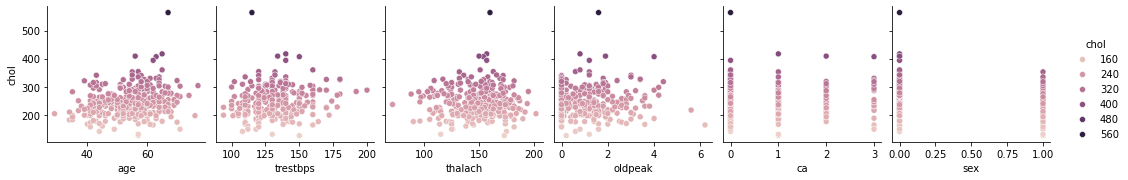

In [11]:
sns.pairplot(data=df_cholesterol_clean, y_vars=["chol"], hue="chol")

### Part 1 Problem 6

I would standardize the data to make it a bit better conditioned, especially since the scales are very different for each of the features.

Just for fun, I'll keep the outlier, though it is probably better to remove it.

In [13]:
scaler_chol = sklearn.preprocessing.RobustScaler()

### Part 1 Problem 7

I'll try using ElasticNet with the usual 70%-30% train-test split and the RobustScaler.  The data doesn't look extremely linear, so better to use something more flexible with the hyperparameters and regularization than the standard ordinary least squares.

In [14]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    df_cholesterol_clean.drop(columns="chol"), 
    df_cholesterol_clean["chol"],
    test_size=0.3, 
    random_state=42
)
X_train_scaled = scaler_chol.fit_transform(X_train) # standardizes X_train data

### Part 1 Problem 8

We can try either the mean square error or the R2.

### Part 1 Problem 9

With `ElasticNet`, you can actually use the built-in `ElasticNetCV` model to automatically perform cross-validation for the best hyperparameters.

But, we didn't cover it in class, so we'll do the ol' `GridSearchCV` and `KFold` method of cross-validation, which you'll have to do for any model that doesn't have it built-in anyway.  We'll do it with 5-fold cross-validation so we have a good balance.

#### Trying with MSE

In [15]:
model_chol = sklearn.linear_model.ElasticNet()
cv_chol_mse = sklearn.model_selection.GridSearchCV(
    estimator=model_chol,
    param_grid={
        'alpha': np.arange(0.01, 5.0, 0.01),  # parameters of ElasticNet
        'l1_ratio': np.arange(0.1, 1.0, 0.1),  # parameters of ElasticNet
    },
    n_jobs=3, # number of jobs run in parallel
    cv=sklearn.model_selection.KFold(n_splits=5), #Kfold for cross-validation
    scoring=sklearn.metrics.make_scorer(
        sklearn.metrics.mean_squared_error,
        greater_is_better=False),
    return_train_score=True
)

In [16]:
cv_chol_mse.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ElasticNet(), n_jobs=3,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46...
       4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6 , 4.61, 4.62,
       4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7 , 4.71, 4.72, 4.73,
       4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.8 , 4.81, 4.82, 4.83, 4.84,
       4.85, 4.86, 4.87, 4.88, 4.89, 4.9 , 4.91, 4.92, 4.93, 4.94, 4.95,
       4.96, 4.97, 4.98, 4.99]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [17]:
print(cv_chol_mse.fit(X_train_scaled, y_train))

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ElasticNet(), n_jobs=3,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46...
       4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6 , 4.61, 4.62,
       4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7 , 4.71, 4.72, 4.73,
       4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.8 , 4.81, 4.82, 4.83, 4.84,
       4.85, 4.86, 4.87, 4.88, 4.89, 4.9 , 4.91, 4.92, 4.93, 4.94, 4.95,
       4.96, 4.97, 4.98, 4.99]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))


In [18]:
cv_chol_mse.best_estimator_.score(scaler_chol.transform(X_test), y_test)

0.03907528048319642

In [19]:
cv_chol_mse.best_params_

{'alpha': 0.32, 'l1_ratio': 0.9}

In [20]:
sklearn.metrics.mean_absolute_error(cv_chol_mse.best_estimator_.predict(scaler_chol.transform(X_test)), y_test)

37.582840227912726

#### Trying with R2

In [21]:
model_chol = sklearn.linear_model.ElasticNet()
cv_chol_r2 = sklearn.model_selection.GridSearchCV(
    estimator=model_chol,
    param_grid={
        'alpha': np.arange(0.01, 5.0, 0.01),  # no prefix "regressor__" since we did not pass in a pipeline
        'l1_ratio': np.arange(0.1, 1.0, 0.1),  # no prefix "regressor__" since we did not pass in a pipeline
    },
    n_jobs=3,
    cv=sklearn.model_selection.KFold(n_splits=5),
    scoring='r2',  # use "r2" as indicated in the GridSearchCV documentation r sqaured
    return_train_score=True
)

In [22]:
cv_chol_r2.fit(X_train_scaled, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=ElasticNet(), n_jobs=3,
             param_grid={'alpha': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46...
       4.41, 4.42, 4.43, 4.44, 4.45, 4.46, 4.47, 4.48, 4.49, 4.5 , 4.51,
       4.52, 4.53, 4.54, 4.55, 4.56, 4.57, 4.58, 4.59, 4.6 , 4.61, 4.62,
       4.63, 4.64, 4.65, 4.66, 4.67, 4.68, 4.69, 4.7 , 4.71, 4.72, 4.73,
       4.74, 4.75, 4.76, 4.77, 4.78, 4.79, 4.8 , 4.81, 4.82, 4.83, 4.84,
       4.85, 4.86, 4.87, 4.88, 4.89, 4.9 , 4.91, 4.92, 4.93, 4.94, 4.95,
       4.96, 4.97, 4.98, 4.99]),
                         'l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
             return_train_score=True, scoring='r2')

In [23]:
cv_chol_r2.best_estimator_.score(scaler_chol.transform(X_test), y_test)

0.04351014031889988

In [24]:
cv_chol_r2.best_params_

{'alpha': 0.56, 'l1_ratio': 0.9}

In [25]:
sklearn.metrics.mean_absolute_error(cv_chol_r2.best_estimator_.predict(scaler_chol.transform(X_test)), y_test)

37.482783292655235

Looks like R2 as the scoring function gives a better R2 than MSE.  L1 ratio seems to be 0.9 in both cases.  The MAE is smaller with the R2 cross-validation as well, so we'll go ahead and use its' best alpha of 0.56.

### Part 1 Problem 10

In [26]:
final_model_chol = sklearn.linear_model.ElasticNet(
    alpha=0.56,
    l1_ratio=0.9
)

In [27]:
final_model_chol.fit(X_train_scaled, y_train)

ElasticNet(alpha=0.56, l1_ratio=0.9)

In [28]:
final_model_chol.score(scaler_chol.transform(X_test), y_test)

0.04351014031889988

In [27]:
sklearn.metrics.mean_squared_error(final_model_chol.predict(scaler_chol.transform(X_test)), y_test)

2153.1290529022026

In [28]:
sklearn.metrics.mean_absolute_error(final_model_chol.predict(scaler_chol.transform(X_test)), y_test)

37.482783292655235

## Part 2

I'll just show a final pipeline here. Up to you which feature selector to choose; I just used `SelectKBest` where we can try 3-5 features and see how many we really need using the grid search.

In [29]:
# note: train_test_split() must be used before passing the training dataset to the pipeline.

X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    df_cholesterol_clean.drop(columns="chol"), 
    df_cholesterol_clean["chol"],
    test_size=0.3,
    random_state=7
)

chol_pipeline_steps = [
    ("polyfeatures", sklearn.preprocessing.PolynomialFeatures(
        degree=2, interaction_only=False
    )),
    ("selector", sklearn.feature_selection.SelectKBest(
        sklearn.feature_selection.f_regression
    )),
    ("scaler", sklearn.preprocessing.RobustScaler()),
    ("regressor", sklearn.linear_model.ElasticNet()), 
]

chol_pipeline = sklearn.pipeline.Pipeline(chol_pipeline_steps)

chol_pipeline_cv = sklearn.model_selection.GridSearchCV(
    estimator=chol_pipeline,
    param_grid={
        'selector__k': range(3, 6),
        'regressor__alpha': np.arange(0.1, 3.0, 0.1),
        'regressor__l1_ratio': np.arange(0.1, 1.0, 0.1),
    },
    n_jobs=3,
    cv=sklearn.model_selection.KFold(n_splits=5),
    scoring='r2',  # use "r2" as indicated in the GridSearchCV documentation
    return_train_score=True
)

In [30]:
chol_pipeline_cv.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('polyfeatures', PolynomialFeatures()),
                                       ('selector',
                                        SelectKBest(score_func=<function f_regression at 0x000001EBCE0330A0>)),
                                       ('scaler', RobustScaler()),
                                       ('regressor', ElasticNet())]),
             n_jobs=3,
             param_grid={'regressor__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9]),
                         'regressor__l1_ratio': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'selector__k': range(3, 6)},
             return_train_score=True, scoring='r2')

In [31]:
chol_pipeline_cv.best_score_

-0.048057075629163504

In [32]:
chol_pipeline_cv.best_params_

{'regressor__alpha': 2.9000000000000004,
 'regressor__l1_ratio': 0.1,
 'selector__k': 5}

In [33]:
chol_pipeline_cv.best_estimator_.named_steps["selector"].get_support()

array([False, False, False, False, False, False,  True, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False,  True, False,
        True])

In [34]:
chol_pipeline_cv.best_estimator_.named_steps["polyfeatures"].get_feature_names_out()[chol_pipeline_cv.best_estimator_.named_steps["selector"].get_support()]

array(['sex', 'trestbps sex', 'thalach sex', 'ca^2', 'sex^2'],
      dtype=object)

In [35]:
sklearn.metrics.mean_absolute_error(chol_pipeline_cv.best_estimator_.predict(X_test), y_test)

39.772453555187

In [38]:
chol_pipeline_cv.best_estimator_.named_steps["polyfeatures"].get_feature_names_out()

array(['1', 'age', 'trestbps', 'thalach', 'oldpeak', 'ca', 'sex', 'age^2',
       'age trestbps', 'age thalach', 'age oldpeak', 'age ca', 'age sex',
       'trestbps^2', 'trestbps thalach', 'trestbps oldpeak',
       'trestbps ca', 'trestbps sex', 'thalach^2', 'thalach oldpeak',
       'thalach ca', 'thalach sex', 'oldpeak^2', 'oldpeak ca',
       'oldpeak sex', 'ca^2', 'ca sex', 'sex^2'], dtype=object)